In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from gluonts.dataset.repository import dataset_recipes

from uni2ts.eval_util.data import get_gluonts_test_dataset
from uni2ts.eval_util.plot import plot_next_multi
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from uni2ts.model.moirai_moe import MoiraiMoEForecast, MoiraiMoEModule

/mnt/vdb/abenechehab/conda_envs/adapters_ttm_uv/lib/python3.10/site-packages/gluonts/dataset/artificial/_base.py:84: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  self.freq: BaseOffset = to_offset(freq)
/mnt/vdb/abenechehab/conda_envs/adapters_ttm_uv/lib/python3.10/site-packages/uni2ts/common/env.py:43: UserWarning: Failed to load .env file.
  warnings.warn("Failed to load .env file.")


In [2]:
import os

os.environ["HF_HOME"] = "/mnt/vdb/hugguingface/"

### Settings
SIZE: model size, select the model size of Moirai to perform inference with

CTX: context length, how many time steps the model will take as input for inference

PSZ: patch size, how many time steps to perform patching with

BSZ: batch size, number of samples in each batch for inference

In [3]:
MODEL = "moirai"  # model name: choose from {'moirai', 'moirai-moe'}
SIZE = "small"  # model size: choose from {'small', 'base', 'large'}
CTX = 512  # context length: any positive integer
PSZ = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 32  # batch size: any positive integer

### Prepare datasets and model

In [4]:
# List of available datasets:
sorted(dataset_recipes.keys())

['ETTh1',
 'ETTh2',
 'ETTm1',
 'ETTm2',
 'METR_LA',
 'airpassengers',
 'australian_electricity_demand',
 'bitcoin',
 'bitcoin_with_missing',
 'car_parts_with_missing',
 'car_parts_without_missing',
 'cif_2016',
 'cif_2016_12',
 'cif_2016_6',
 'constant',
 'covid_deaths',
 'covid_mobility',
 'dominick',
 'elecdemand',
 'electricity',
 'electricity_hourly',
 'electricity_nips',
 'electricity_weekly',
 'exchange_rate',
 'exchange_rate_nips',
 'extended_web_traffic_with_missing',
 'fred_md',
 'hospital',
 'istanbul_traffic',
 'jena_weather',
 'kaggle_web_traffic_weekly',
 'kaggle_web_traffic_with_missing',
 'kaggle_web_traffic_without_missing',
 'kdd_cup_2018_with_missing',
 'kdd_cup_2018_without_missing',
 'london_smart_meters_with_missing',
 'london_smart_meters_without_missing',
 'm1_monthly',
 'm1_quarterly',
 'm1_yearly',
 'm3_monthly',
 'm3_other',
 'm3_quarterly',
 'm3_yearly',
 'm4_daily',
 'm4_hourly',
 'm4_monthly',
 'm4_quarterly',
 'm4_weekly',
 'm4_yearly',
 'm5',
 'monash_m3_

In [21]:
# Load dataset using loader utils
test_data, metadata = get_gluonts_test_dataset(
    "electricity_hourly",
    prediction_length=96,  # regenerate=False
)
metadata

Download electricity_hourly_dataset.zip:: 11.3MB [00:01, 6.01MB/s]
creating json files: 100%|██████████| 321/321 [00:00<00:00, 58783.25it/s]


MetaData(freq='H', target_dim=1, prediction_length=96, feat_dynamic_real_dim=0, past_feat_dynamic_real_dim=0, split='test')

In [22]:
# Prepare model
if MODEL == "moirai":
    model = MoiraiForecast(
        module=MoiraiModule.from_pretrained(
            f"Salesforce/moirai-1.1-R-{SIZE}",
        ),
        prediction_length=metadata.prediction_length,
        context_length=CTX,
        patch_size=PSZ,
        num_samples=100,
        target_dim=metadata.target_dim,
        feat_dynamic_real_dim=metadata.feat_dynamic_real_dim,
        past_feat_dynamic_real_dim=metadata.past_feat_dynamic_real_dim,
    )
elif MODEL == "moirai-moe":
    model = MoiraiMoEForecast(
        module=MoiraiMoEModule.from_pretrained(
            f"Salesforce/moirai-moe-1.0-R-{SIZE}",
        ),
        prediction_length=metadata.prediction_length,
        context_length=CTX,
        patch_size=16,
        num_samples=100,
        target_dim=metadata.target_dim,
        feat_dynamic_real_dim=metadata.feat_dynamic_real_dim,
        past_feat_dynamic_real_dim=metadata.past_feat_dynamic_real_dim,
    )

In [23]:
test_data

TestData(dataset=Map(fn=<gluonts.dataset.common.ProcessDataEntry object at 0x7f1e1ba48df0>, iterable=JsonLinesFile(path=PosixPath('/home/abenechehab/.gluonts/datasets/electricity_hourly/test/data.json.gz'), start=0, n=None, line_starts=[0, 123822, 273540, 386663, 544646, 701990, 863437, 994600, 1166279, 1323499, 1480242, 1637044, 1794941, 1951608, 2104155, 2262013, 2432677, 2564276, 2721253, 2880666, 3025143, 3156785, 3322512, 3460307, 3597804, 3755704, 3913101, 4071001, 4203197, 4361117, 4505923, 4663863, 4821763, 4977286, 5134390, 5318603, 5467717, 5625073, 5783233, 5930921, 6063591, 6247792, 6407605, 6565427, 6721018, 6878918, 7036818, 7178290, 7334739, 7479127, 7637026, 7794926, 7942981, 8100881, 8258781, 8398680, 8583028, 8740911, 8885609, 9048661, 9209620, 9368799, 9526628, 9684050, 9841950, 9997394, 10155294, 10313153, 10470940, 10622043, 10779761, 10928494, 11062391, 11220292, 11377255, 11535155, 11702002, 11859980, 12043318, 12201275, 12360205, 12522917, 12673761, 12831768, 12

In [24]:
predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

### Make predictions

In [25]:
inp = next(input_it)  # input / lookback window
label = next(label_it)  # label / forecast horizon
forecast = next(forecast_it)  # predictions (GluonTS Forecast object)

/mnt/vdb/abenechehab/conda_envs/adapters_ttm_uv/lib/python3.10/site-packages/gluonts/dataset/common.py:262: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return pd.Period(val, freq)


In [26]:
inp.keys(), label.keys()

(dict_keys(['target', 'start', 'item_id', 'feat_static_cat']),
 dict_keys(['target', 'start', 'item_id', 'feat_static_cat']))

In [27]:
inp["target"].shape, label["target"].shape

((26208,), (96,))

Moirai produces a _probabilistic forecast_, in the form of a mixture distribution.
```forecast``` is a sample forecast, taking ```num_samples=100``` samples from the mixture distribution per time step.

In [28]:
forecast.samples.shape

(100, 96)

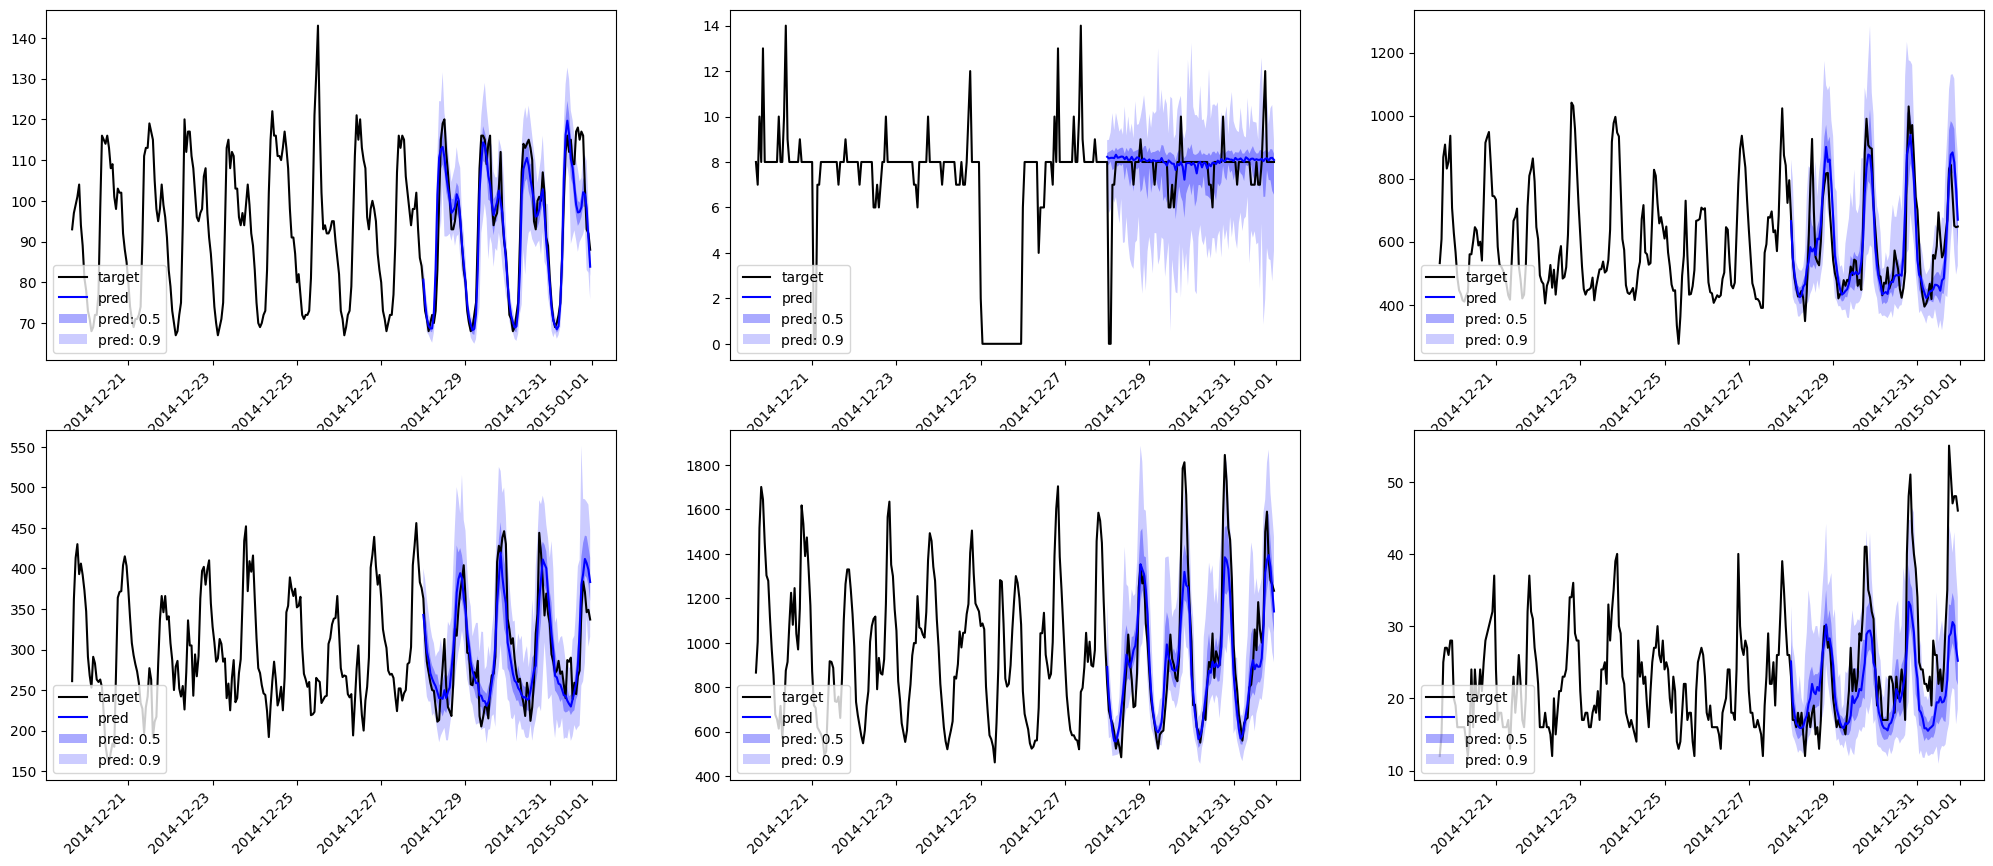

In [29]:
# Visualize forecasts
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
plot_next_multi(
    axes,
    input_it,
    label_it,
    forecast_it,
    context_length=200,
    intervals=(0.5, 0.9),
    dim=None,
    name="pred",
    show_label=True,
)